In [20]:
import os
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import category_encoders as ce
from scipy import stats
from typing import List, Callable, ClassVar
from scipy.stats import boxcox
from keras.initializers import he_normal
from keras.layers import Dropout,BatchNormalization

### Original data

In [2]:
data = pd.read_csv('../raw_data/6_months.csv')

## Running preprocessor

### Renaming the "dayofweek" column so that cyclical encoding not applied. 

In [3]:
data.rename(columns={"dayofweek": "day"}, inplace=True)

In [4]:
model_columns = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer', "day",
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax']

In [5]:
model_columns_incltarg = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer', "day",
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax', 'Score_Z_score_0_50']

In [6]:
min_max_col =['TravelHorizonDays', "day"]

In [7]:
log_columns = ['extra_travel_distance_ratio', 'PricePerPax', 'TravelDistanceKm', 'total_layover_time_ratio']

In [8]:
# Running Antonis new mega preprocessor

processed_data, prescalars = all_preprocessing(data, model_columns, scale_itin_redirects,
                                               'Score_Z_score_0_50', target_func_param1='ItineraryRedirects',
                                               target_func_param2=0, target_func_param3=50, log_transform_columns=log_columns,
                                               operator_encoding=False, min_max_scaling=min_max_col, od_encoding=False)

/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
processed_data.head()

,TravelDistanceKm,TravelHorizonDays,SelfTransfer,day,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
0,7.440734,0.288889,1,0.833333,0.0,0.693147,5.646182,1.251268
1,7.440734,0.288889,1,0.166667,0.0,0.693147,5.436399,1.050187
2,7.440734,0.288889,1,0.333333,0.0,0.693147,5.309560,0.648027
3,7.204893,0.844444,1,0.833333,0.0,0.693147,5.163900,0.340740
4,7.204893,0.844444,1,0.833333,0.0,0.693147,5.323571,0.340740


In [11]:
processed_data.describe()

,TravelDistanceKm,TravelHorizonDays,SelfTransfer,day,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
count,1.362368e+07,1.409269e+07,1.409269e+07,1.409269e+07,1.409269e+07,1.362368e+07,1.408677e+07,1.362361e+07
mean,7.656385e+00,4.199395e-01,9.534667e-01,4.937394e-01,7.446066e-02,7.154609e-01,4.992440e+00,8.437104e-01
std,1.019737e+00,2.875081e-01,2.106370e-01,3.385776e-01,1.291145e-01,7.520184e-02,1.037817e+00,6.888867e-01
min,4.304065e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.247796e-01,4.510756e-01,0.000000e+00
25%,6.903747e+00,1.666667e-01,1.000000e+00,1.666667e-01,0.000000e+00,6.931472e-01,4.199830e+00,4.810052e-01
50%,7.536897e+00,3.777778e-01,1.000000e+00,5.000000e-01,0.000000e+00,6.931472e-01,4.915005e+00,5.823696e-01
75%,8.570165e+00,6.555556e-01,1.000000e+00,8.333333e-01,1.307702e-01,6.997287e-01,5.838769e+00,9.346123e-01
max,9.852405e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.931472e-01,4.071737e+00,2.090079e+01,5.000000e+01


In [12]:
processed_data["Score_Z_score_0_50"].fillna(0, inplace=True)

In [13]:
processed_data.dropna(inplace=True)

### Checking the distribution of the target (Score_Z_score_0_50)


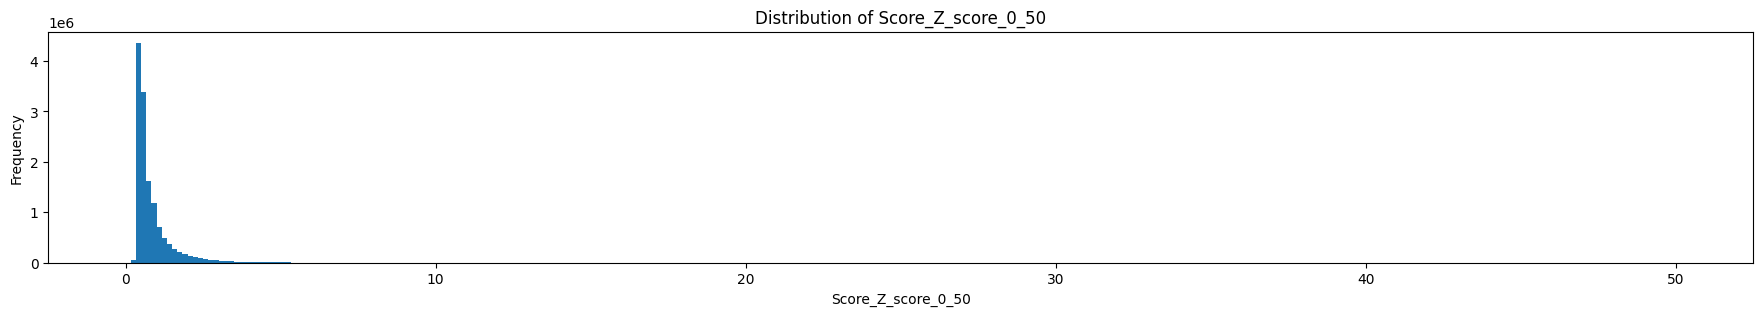

In [14]:
plt.figure(figsize=(22, 3))
plt.hist(processed_data["Score_Z_score_0_50"], bins=300)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50")
plt.show()


## Continuing the Pre-Processing

In [15]:
model_data = processed_data[model_columns_incltarg].copy()


In [16]:
model_data["SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [17]:
# Convert to cyclical features
model_data["sin_days"] = np.sin(2 * np.pi * model_data["day"] / 7)
model_data["cos_days"] = np.cos(2 * np.pi * model_data["day"] / 7)

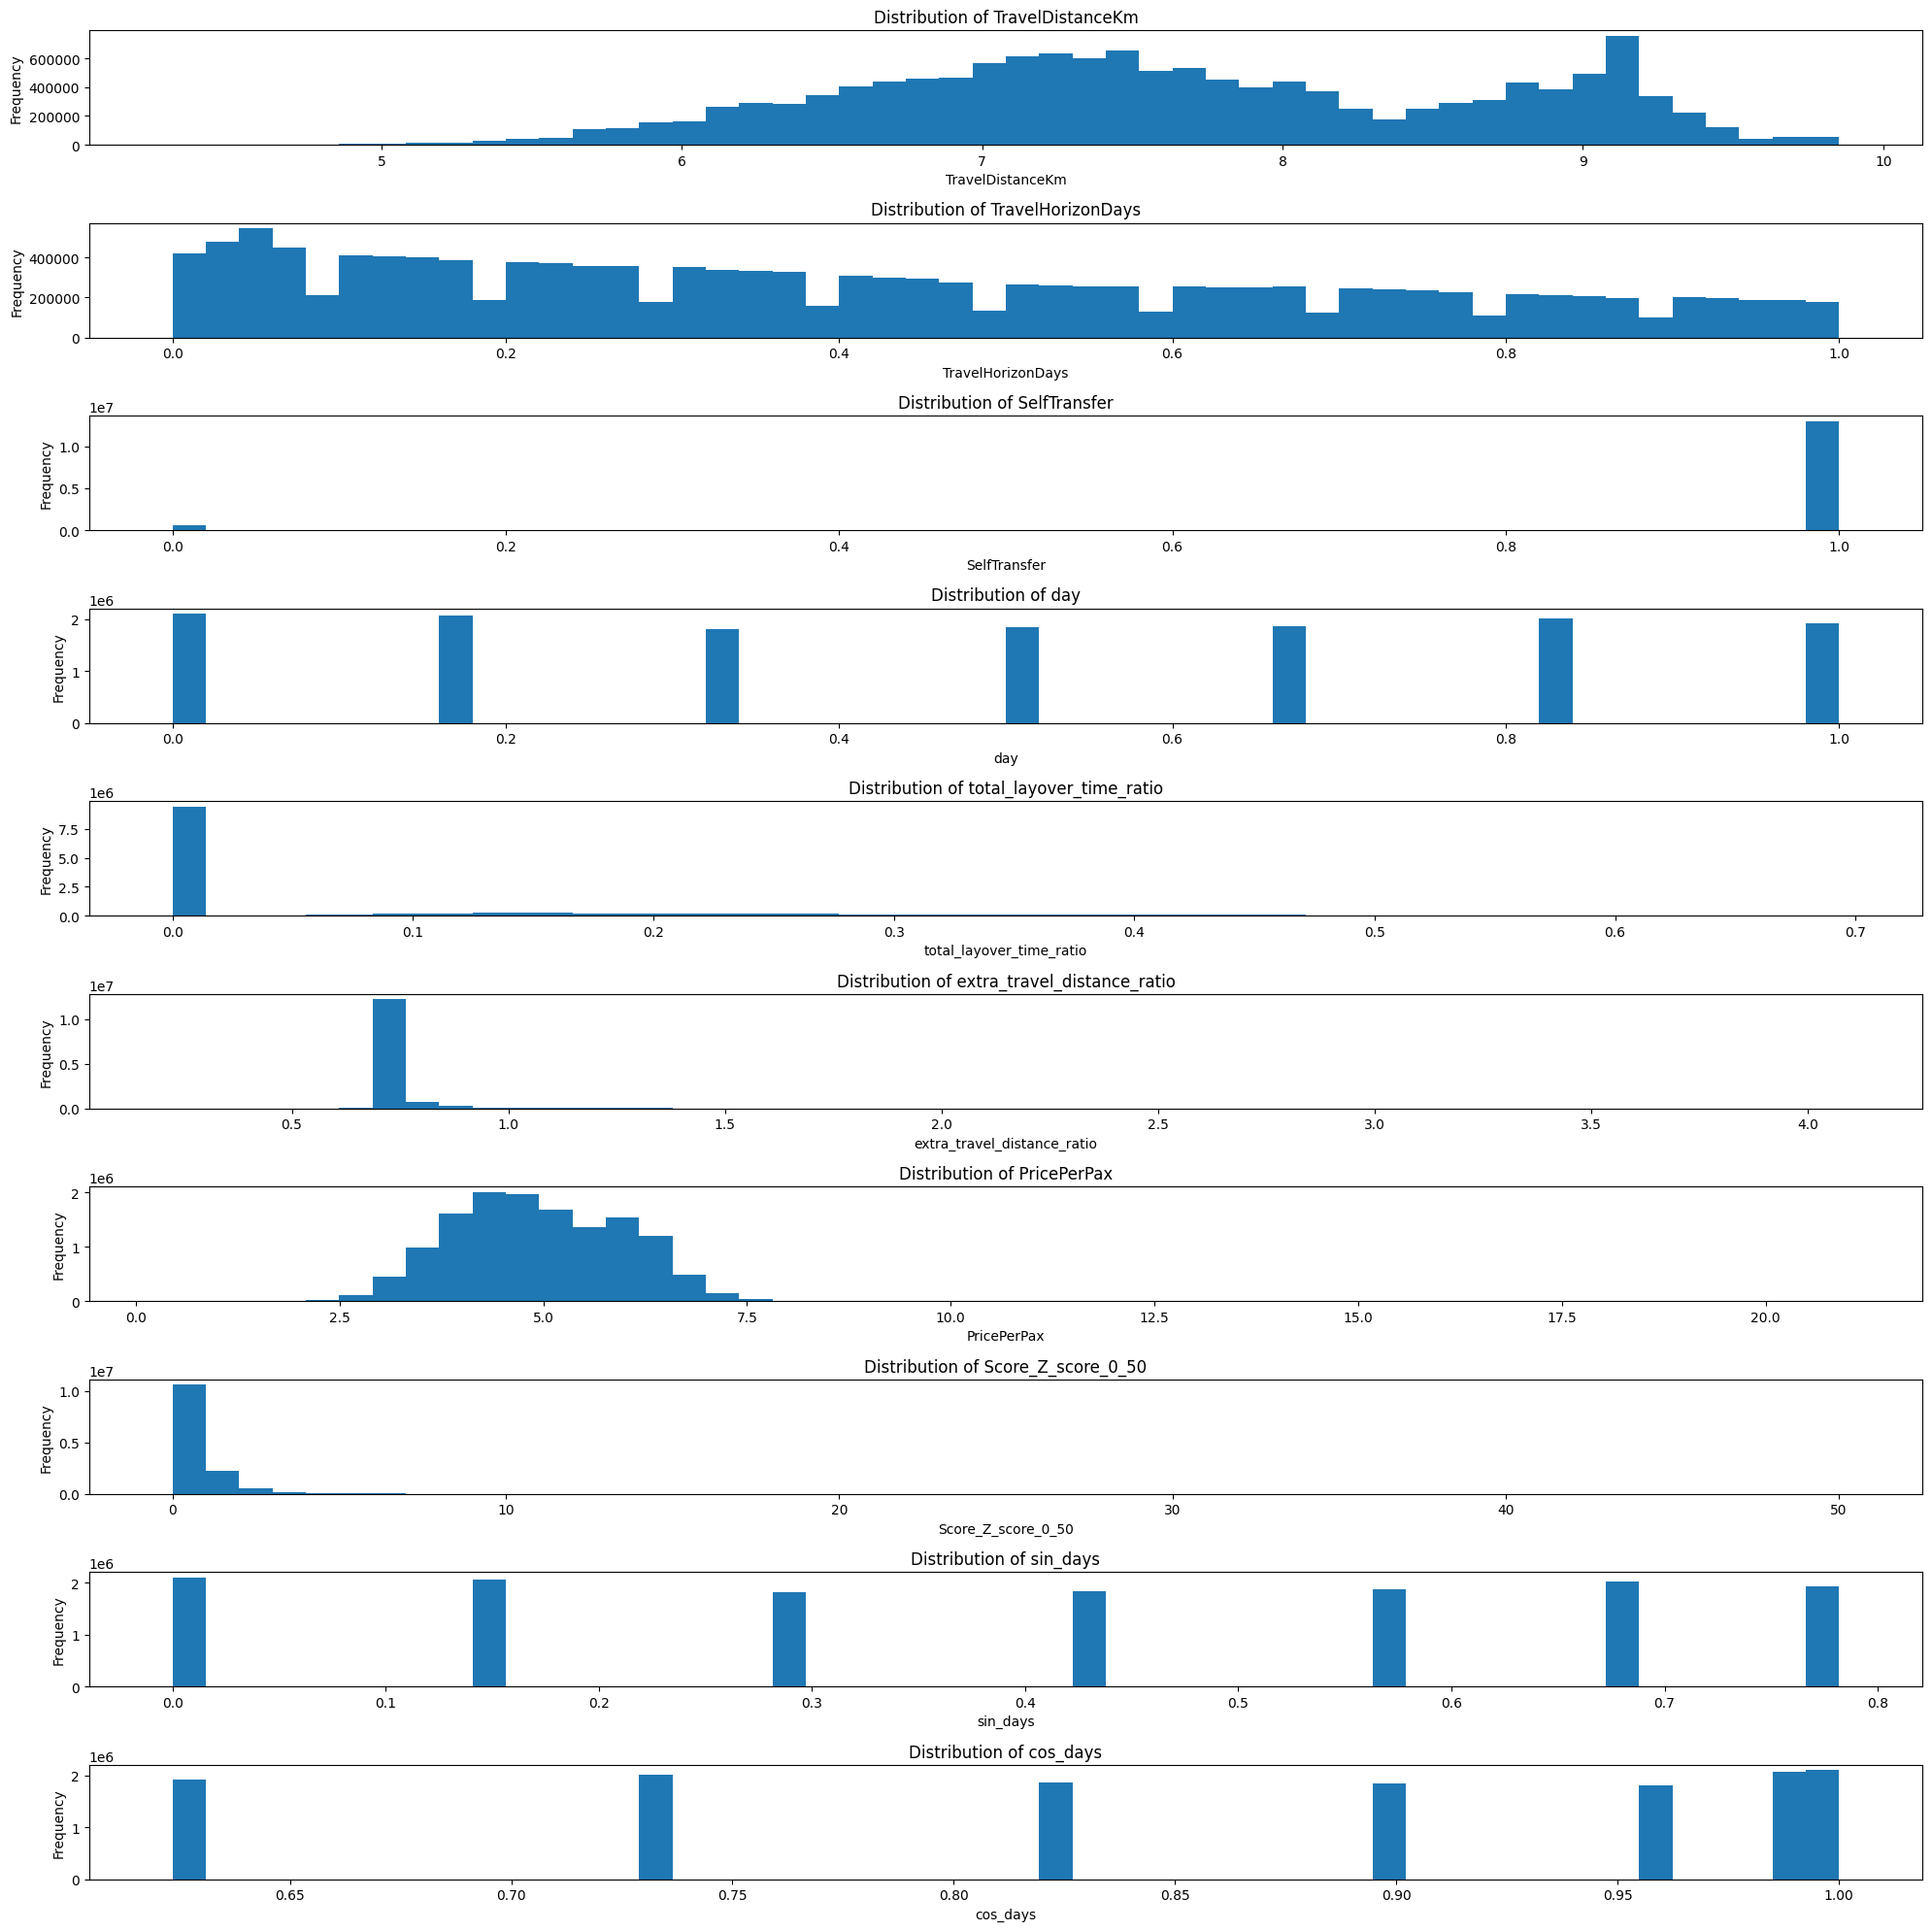

In [18]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist(bins=50)
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


New target reqiures replacment of NaNs by zeros

In [21]:
X_train = model_data.drop(columns=["Score_Z_score_0_50", "day"])
y_train = model_data["Score_Z_score_0_50"]

In [22]:
model = Sequential()
model.add(layers.Dense(128, input_dim=8, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=1, mode='min', restore_best_weights=True)

In [25]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [26]:
model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/5
21279/21279 [==============================] - 388s 18ms/step - loss: 0.4582 - mae: 0.4120 - val_loss: 0.4505 - val_mae: 0.4008
Epoch 2/5
21279/21279 [==============================] - 400s 19ms/step - loss: 0.4511 - mae: 0.4082 - val_loss: 0.4494 - val_mae: 0.3982
Epoch 3/5
21279/21279 [==============================] - 422s 20ms/step - loss: 0.4506 - mae: 0.4079 - val_loss: 0.4487 - val_mae: 0.4019
Epoch 4/5
21279/21279 [==============================] - 395s 19ms/step - loss: 0.4503 - mae: 0.4078 - val_loss: 0.4499 - val_mae: 0.3951
Epoch 4: early stopping


In [27]:
model.save('model14Jan2_I.h5')


/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# model = load_model('../models/model11Jan24.h5')


## DOHOP TEST SET

In [29]:
dohop_test = pd.read_csv("../raw_data/DohopTest11Dec.csv")
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500


In [30]:
dohop_test["SelfTransfer"] = 1
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1


In [31]:
dohop_test['total_layover_time_ratio'] = dohop_test["connection_time"] / (dohop_test["connection_time"] + dohop_test["total_flight_time"])
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer,total_layover_time_ratio
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1,0.512195
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1,0.247059
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1,0.589744
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1,0.352941
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1,0.346535


In [32]:
dohop_test["extra_travel_distance_ratio"] = dohop_test["total_distance"] / dohop_test["direct_distance"]
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1,0.512195,1.854818
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1,0.247059,1.016140
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1,0.589744,1.197750
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1,0.352941,1.106451
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1,0.346535,1.101503


In [33]:
dohop_test.rename(columns={"total_distance": "TravelDistanceKm", "dayofweek": "day", "days_to_travel": "TravelHorizonDays", "itinerary_fare": "PricePerPax", },inplace=True)
dohop_test.columns


Index(['flights', 'origin_iata', 'destination_iata', 'connection_airport',
       'total_flight_time', 'connection_time', 'TravelHorizonDays', 'day',
       'pax', 'bookings', 'booked_fare', 'TravelDistanceKm', 'direct_distance',
       'PricePerPax', 'SelfTransfer', 'total_layover_time_ratio',
       'extra_travel_distance_ratio'],
      dtype='object')

In [34]:
model_columns


['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'day',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax']

In [35]:
dohop_columns = ['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'day',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax', "bookings"]


In [36]:
dohop_test = dohop_test[dohop_columns].copy()


In [37]:
dohop_test["bookings"].fillna(0, inplace=True)


In [38]:
dohop_test.dropna(inplace=True)
dohop_test.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
day                            0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
bookings                       0
dtype: int64

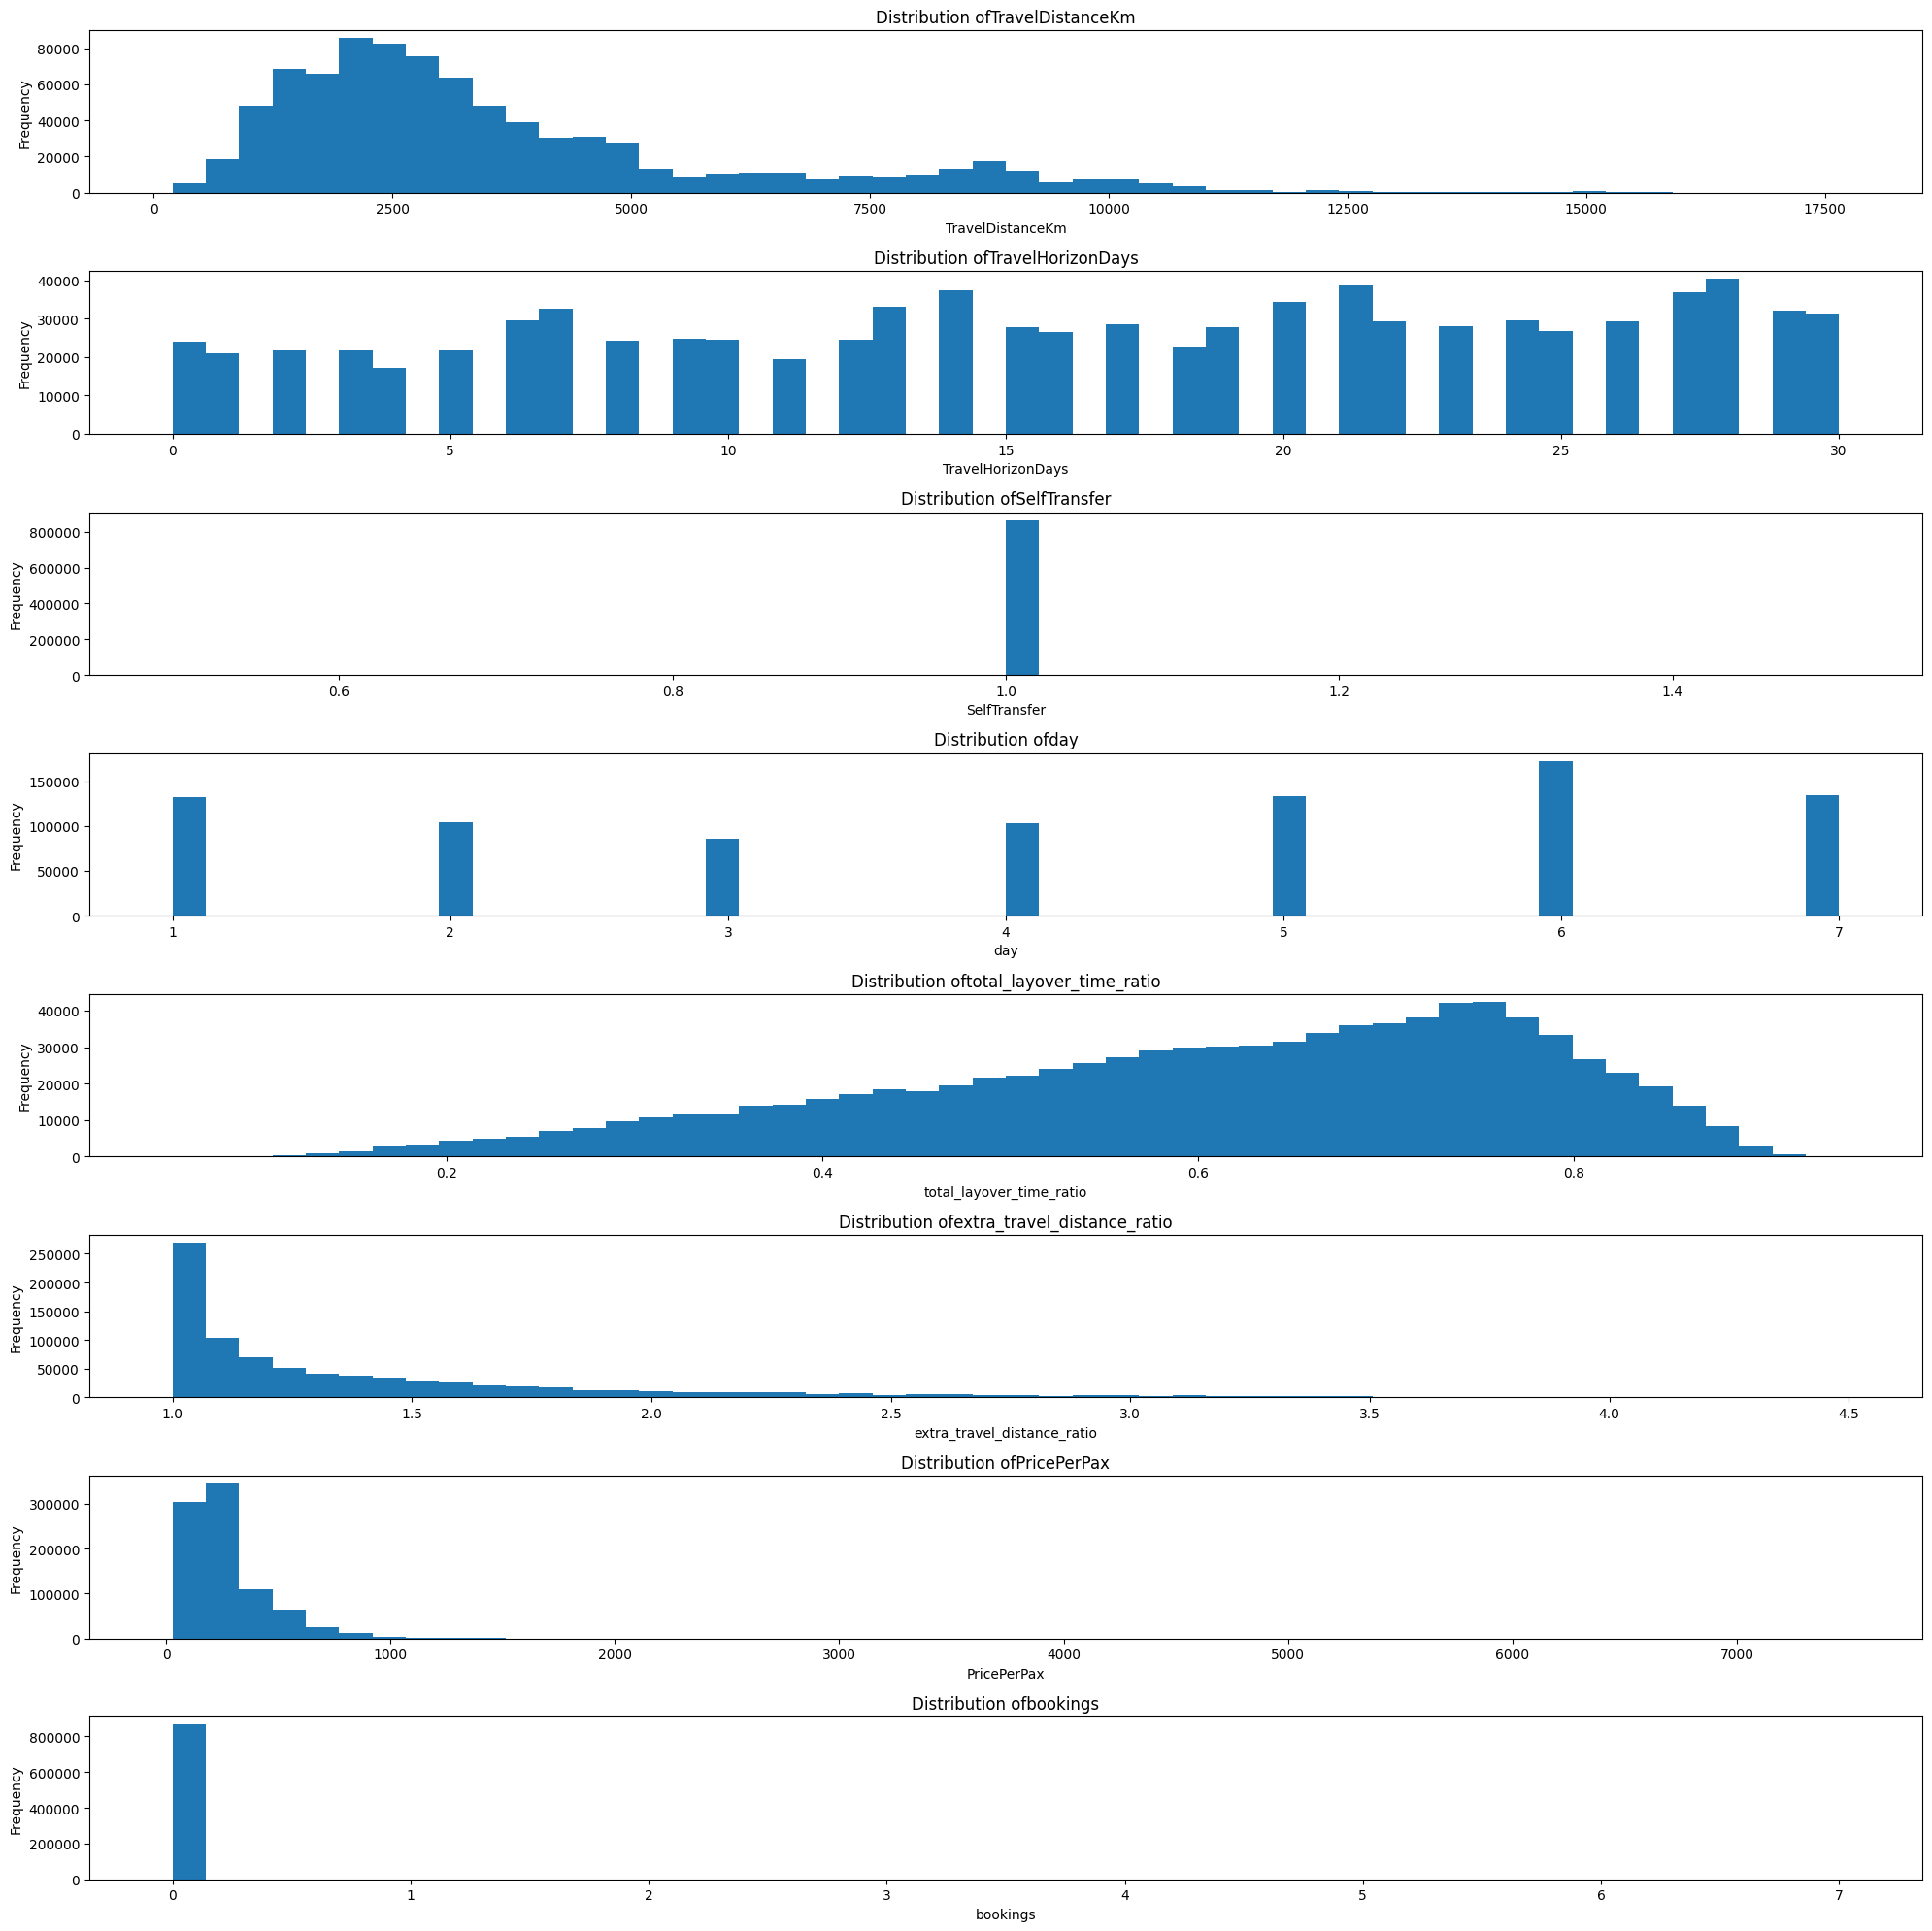

In [39]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(dohop_test.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of{heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [40]:

# Apply the transformation in a loop
for column in log_columns:
    dohop_test.loc[:, column] = np.log1p(dohop_test[column])


In [41]:
dohop_scaler = prescalars.minmax_scaler["TravelHorizonDays"]
dohop_scaler

MinMaxScaler()

In [42]:
dohop_test["TravelHorizonDays"] = dohop_scaler.transform(dohop_test["TravelHorizonDays"].values.reshape(-1, 1))

/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [43]:
dohop_scaler_day = prescalars.minmax_scaler["day"]
dohop_scaler_day

MinMaxScaler()

In [44]:
dohop_test["day"] = dohop_scaler_day.transform(dohop_test["day"].values.reshape(-1,1))

/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [45]:
# Convert to cyclical features
dohop_test["sin_days"] = np.sin(2 * np.pi * dohop_test["day"] / 7)
dohop_test["cos_days"] = np.cos(2 * np.pi * dohop_test["day"] / 7)

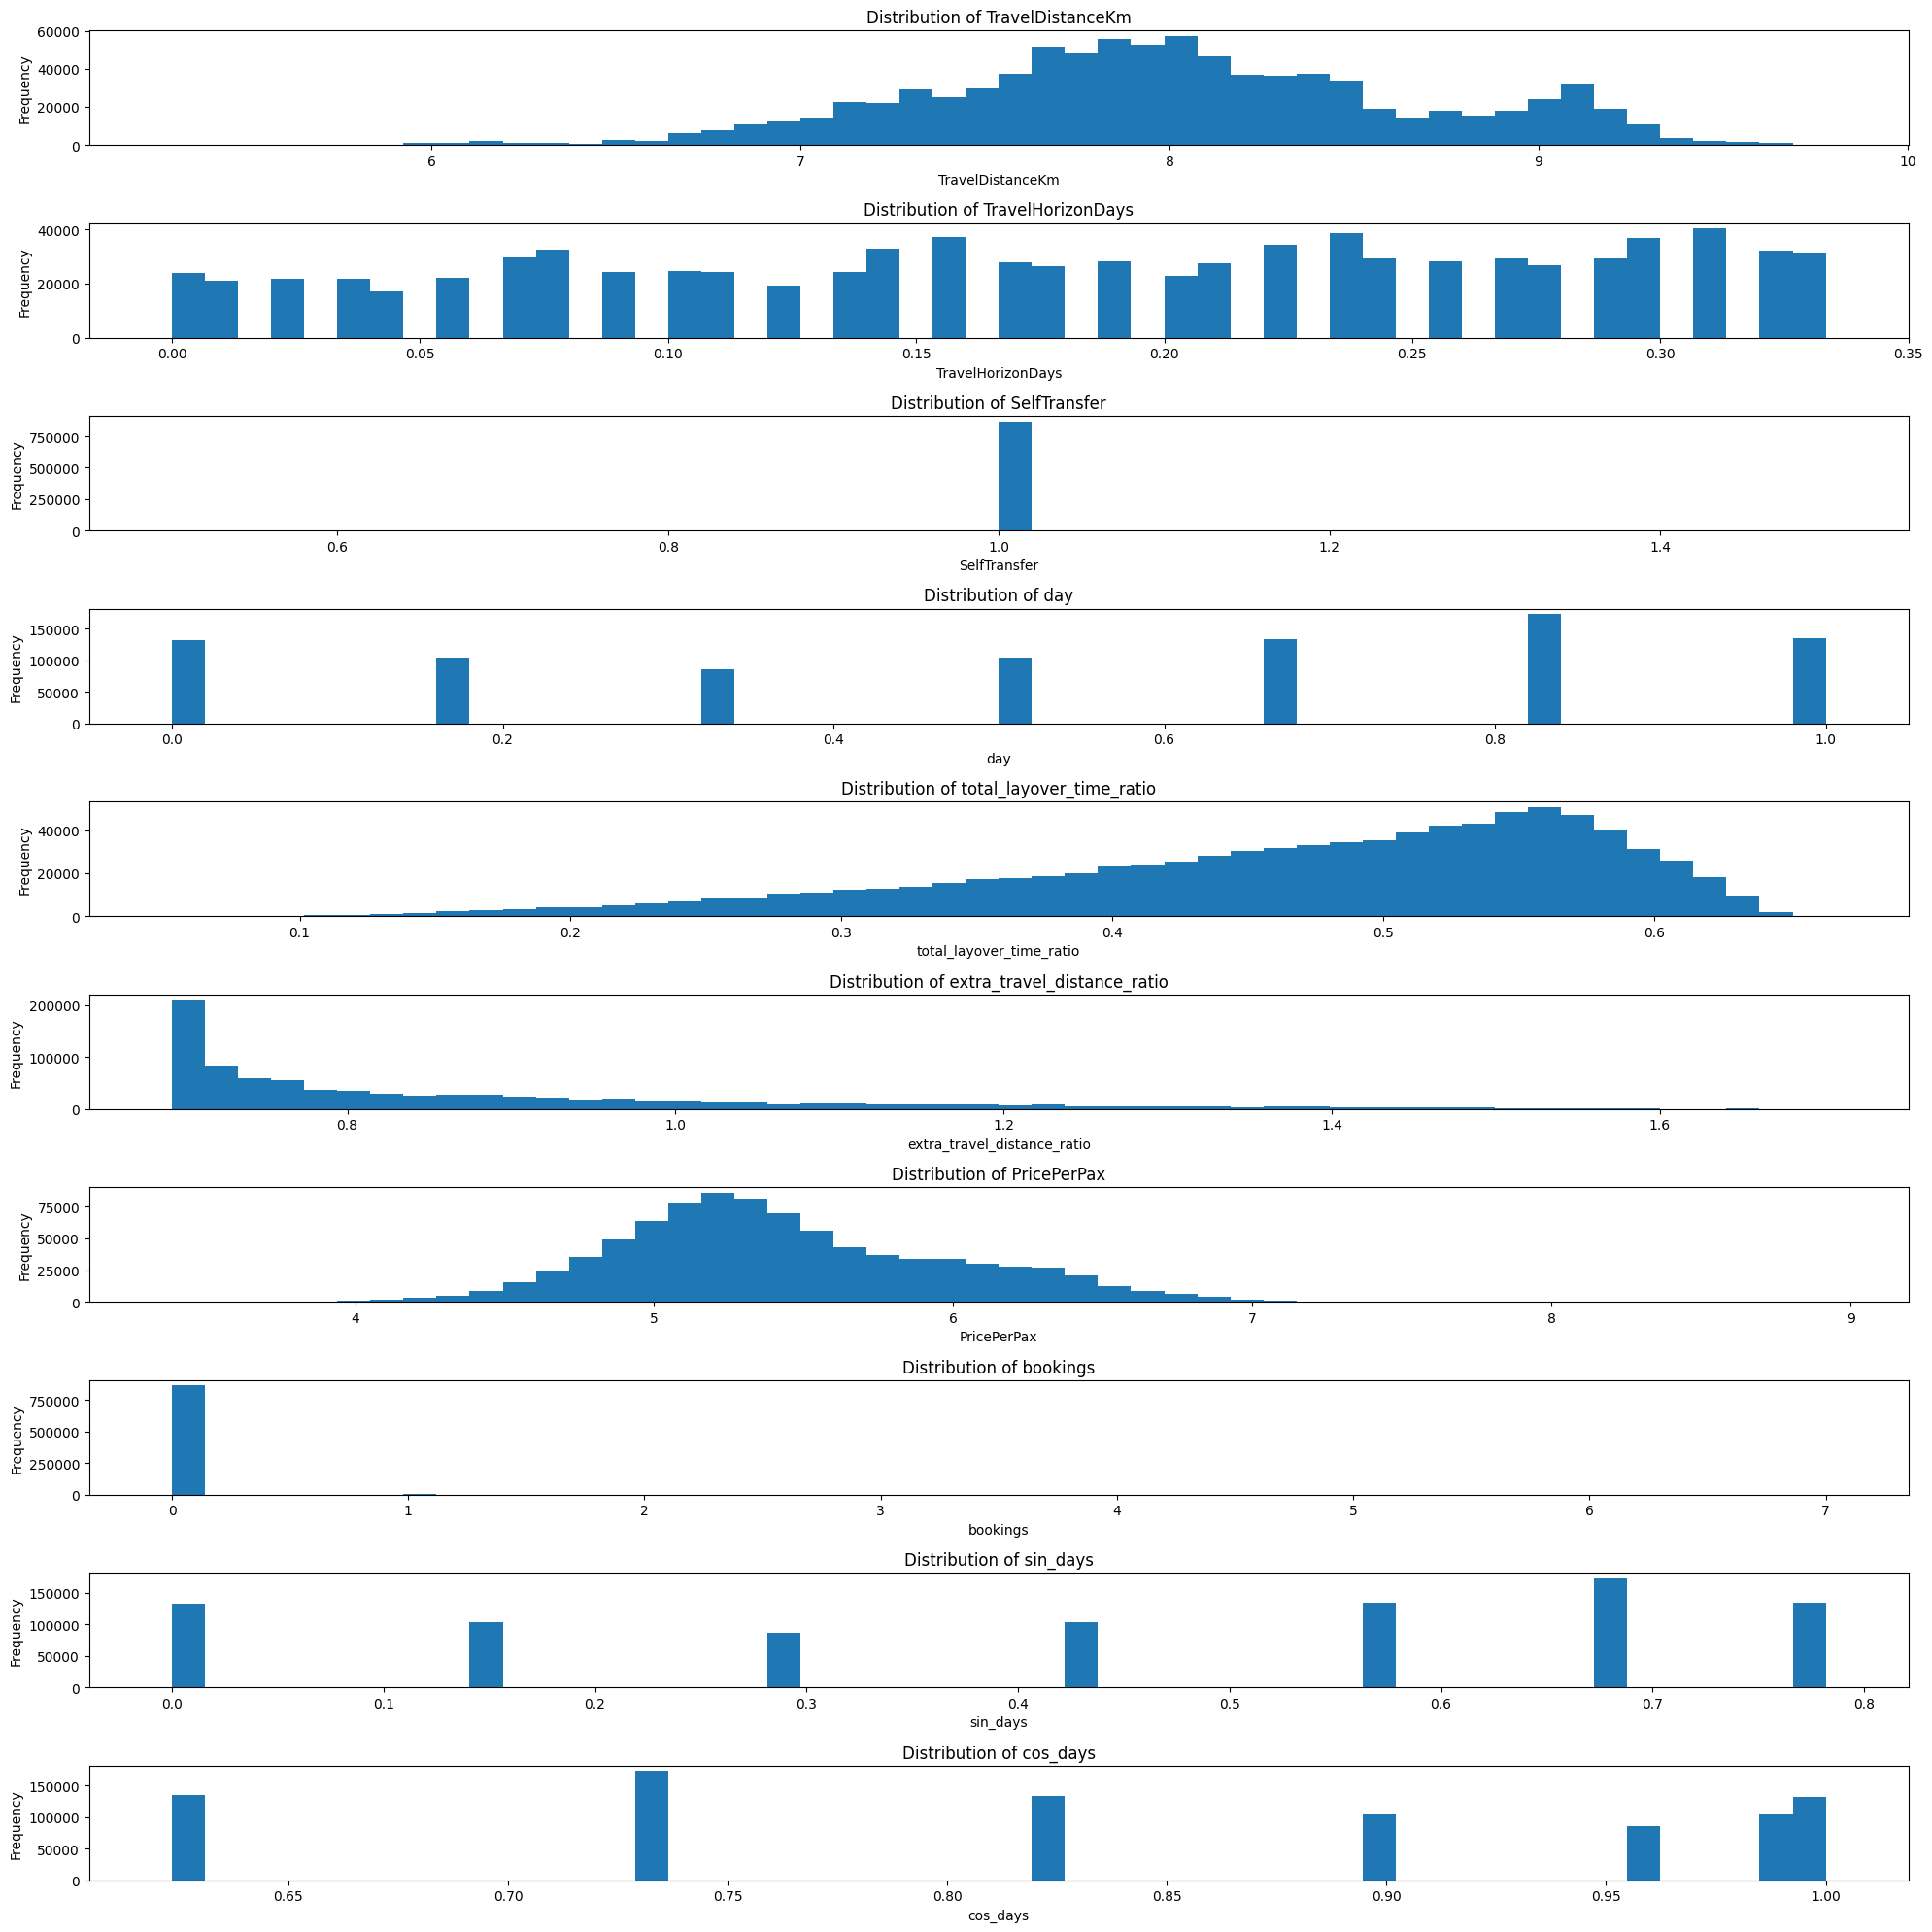

In [46]:
numeric_dohop_test = dohop_test.select_dtypes(include=[np.number])

# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(numeric_dohop_test.columns):
    plt.subplot(len(numeric_dohop_test.columns), 1, i+1)
    numeric_dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [47]:
bookings_column =   dohop_test["bookings"].copy()
dohop_test.drop(columns=["bookings", "day"], inplace=True)


In [48]:
y_dohop_pred = model.predict(dohop_test)


27075/27075 [==============================] - 55s 2ms/step


In [49]:
dohop_test["bookings"] = bookings_column


In [50]:
dohop_test["predicted_score"] = y_dohop_pred.flatten()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


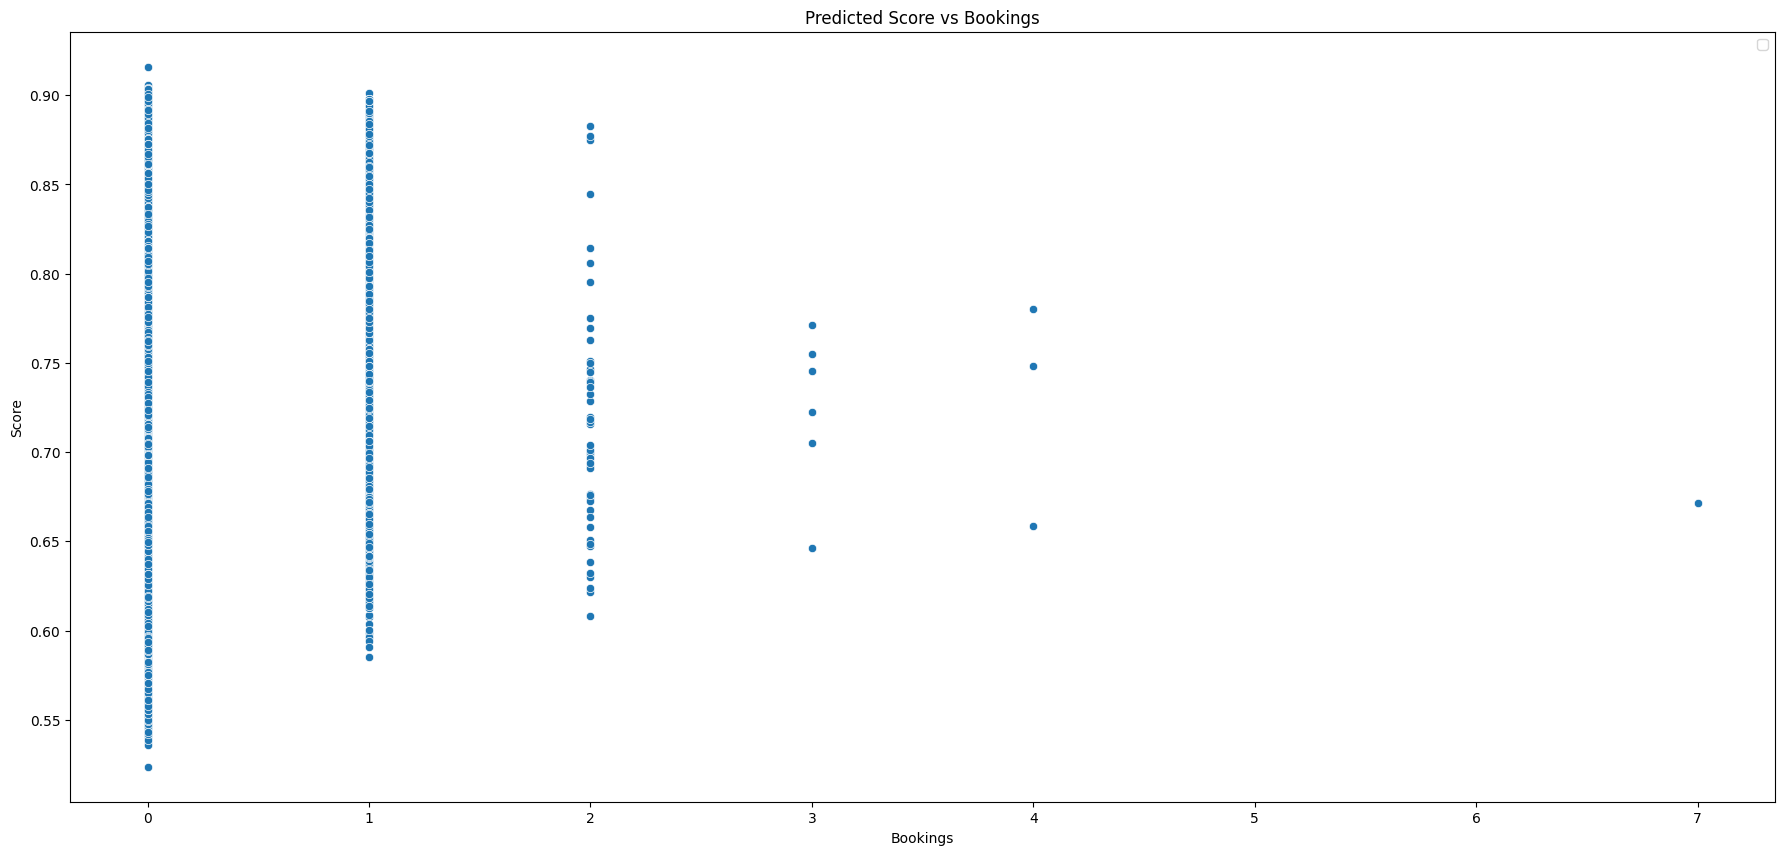

In [51]:
plt.figure(figsize = (22, 10))
sns.scatterplot(data=dohop_test, y=dohop_test["predicted_score"], x=dohop_test["bookings"])
plt.xlabel("Bookings")
plt.ylabel("Score")
plt.legend(loc='upper right')
plt.title("Predicted Score vs Bookings")
plt.show()


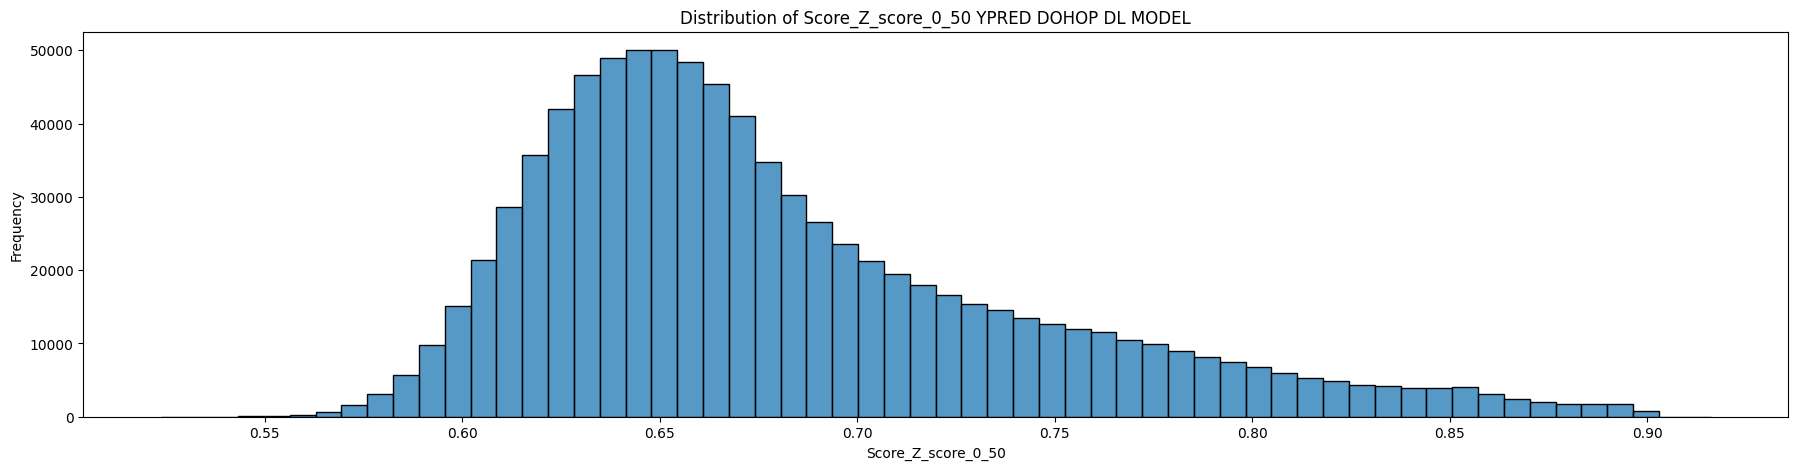

In [52]:
plt.figure(figsize = (22, 5))
sns.histplot(y_dohop_pred.flatten(), bins=60)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50 YPRED DOHOP DL MODEL")
plt.show()


## Classification Results of DL model

In [53]:
# Create a new colummn bucketed into "booked" and "not-booked"
dohop_test["status"] = np.where(dohop_test["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
booked_data = dohop_test[dohop_test["status"] == "booked"]

    # Filter down the dataset to those rows which were not booked
not_booked_data = dohop_test[dohop_test["status"] == "not-booked"]

    # Compute minimum score threshold for booked and not-booked data
min_booked_score = dohop_test.loc[dohop_test["status"] == "booked", "predicted_score"].min()
min_not_booked_score = dohop_test.loc[dohop_test["status"] == "not-booked", "predicted_score"].min()

metrics = {"min_threshold": min_booked_score,
               "total_rows": dohop_test.shape[0],
               "TP": booked_data[dohop_test["predicted_score"] >= min_booked_score].shape[0],
               "FP": not_booked_data[dohop_test["predicted_score"] >= min_booked_score].shape[0],
               "TN": not_booked_data[dohop_test["predicted_score"] < min_booked_score].shape[0],
               "FN": booked_data[dohop_test["predicted_score"] < min_booked_score].shape[0],
               }

/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/1878297786.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "TP": booked_data[dohop_test["predicted_score"] >= min_booked_score].shape[0],
/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/1878297786.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "FP": not_booked_data[dohop_test["predicted_score"] >= min_booked_score].shape[0],
/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/1878297786.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "TN": not_booked_data[dohop_test["predicted_score"] < min_booked_score].shape[0],
/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/1878297786.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "FN": booked_data[dohop_test["predicted_score"] < min_booked_score].shape[0],


In [54]:
metrics

{'min_threshold': 0.58543634,
 'total_rows': 866374,
 'TP': 1000,
 'FP': 857549,
 'TN': 7825,
 'FN': 0}

In [55]:
print(f"TPR is {round(metrics['TP'] / metrics['total_rows'] * 100, ndigits=2)}%")
print(f"FPR is {round(metrics['FP'] / metrics['total_rows'] * 100, ndigits=2)}%")
print(f"TNR is {round(metrics['TN'] / metrics['total_rows'] * 100, ndigits=2)}%")
print(f"FPR is {round(metrics['FN'] / metrics['total_rows'] * 100, ndigits=2)}%")

TPR is 0.12%
FPR is 98.98%
TNR is 0.9%
FPR is 0.0%


## Building Baseline Poisson Regressor Model

In [56]:
baseline = linear_model.PoissonRegressor()

In [57]:
baseline.fit(X_train, y_train)

PoissonRegressor()

## Classification Results of Baseline Model

In [58]:
dohop_test.drop(columns=["bookings", "predicted_score", "status"], inplace=True)
y_dohop_pred_baseline = baseline.predict(dohop_test)
dohop_test["bookings"] = bookings_column
dohop_test["predicted_score_baseline"] = y_dohop_pred_baseline.flatten()

In [59]:
# Create a new colummn bucketed into "booked" and "not-booked"
dohop_test["status"] = np.where(dohop_test["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
booked_data = dohop_test[dohop_test["status"] == "booked"]

    # Filter down the dataset to those rows which were not booked
not_booked_data = dohop_test[dohop_test["status"] == "not-booked"]

    # Compute minimum score threshold for booked and not-booked data
min_booked_score = dohop_test.loc[dohop_test["status"] == "booked", "predicted_score_baseline"].min()
min_not_booked_score = dohop_test.loc[dohop_test["status"] == "not-booked", "predicted_score_baseline"].min()

metrics_baseline = {"min_threshold": min_booked_score,
               "total_rows": dohop_test.shape[0],
               "TP": booked_data[dohop_test["predicted_score_baseline"] >= min_booked_score].shape[0],
               "FP": not_booked_data[dohop_test["predicted_score_baseline"] >= min_booked_score].shape[0],
               "TN": not_booked_data[dohop_test["predicted_score_baseline"] < min_booked_score].shape[0],
               "FN": booked_data[dohop_test["predicted_score_baseline"] < min_booked_score].shape[0],
               }

/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/2842118417.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "TP": booked_data[dohop_test["predicted_score_baseline"] >= min_booked_score].shape[0],
/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/2842118417.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "FP": not_booked_data[dohop_test["predicted_score_baseline"] >= min_booked_score].shape[0],
/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/2842118417.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "TN": not_booked_data[dohop_test["predicted_score_baseline"] < min_booked_score].shape[0],
/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_6174/2842118417.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "FN": booked_data[dohop_test["predicted_score_baseline"] < min_booked_score].shape[0],


In [60]:
metrics_baseline

{'min_threshold': 0.837744478470171,
 'total_rows': 866374,
 'TP': 1000,
 'FP': 851395,
 'TN': 13979,
 'FN': 0}

### Deep Learning Model

In [61]:
print(f"TPR is {round(metrics['TP'] / metrics['total_rows'] * 100, ndigits=2)}%")
print(f"FPR is {round(metrics['FP'] / metrics['total_rows'] * 100, ndigits=2)}%")
print(f"TNR is {round(metrics['TN'] / metrics['total_rows'] * 100, ndigits=2)}%")
print(f"FPR is {round(metrics['FN'] / metrics['total_rows'] * 100, ndigits=2)}%")

TPR is 0.12%
FPR is 98.98%
TNR is 0.9%
FPR is 0.0%


### Baseline Model

In [62]:
print(f"TPR is {round(metrics_baseline['TP'] / metrics_baseline['total_rows'] * 100, ndigits=2)}%")
print(f"FPR is {round(metrics_baseline['FP'] / metrics_baseline['total_rows'] * 100, ndigits=2)}%")
print(f"TNR is {round(metrics_baseline['TN'] / metrics_baseline['total_rows'] * 100, ndigits=2)}%")
print(f"FPR is {round(metrics_baseline['FN'] / metrics_baseline['total_rows'] * 100, ndigits=2)}%")

TPR is 0.12%
FPR is 98.27%
TNR is 1.61%
FPR is 0.0%
